# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [2]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [198]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

In [199]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

gcm.β = [-0.15769146903925968, 0.16691423457105334, 0.006746968060245773]
initializing dispersion using residual sum of squares
gcm.τ = [9.100986872916733]
initializing variance components using MM-Algorithm
gcm.θ = [0.08647295121167434]
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only l

In [200]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [-0.15724541848225881, 0.1622105756389522, 0.008250501994707893]
qc_model.β = [-0.15837253758456013, 0.1669856604575022, 0.006976041170547402]
qc_model.∇β = [-7.303436024841403e-7, 1.8718920102855918e-7, 2.4591593117406774e-7]
θtrue = [0.1]
qc_model.θ = [0.08654997253332694]
qc_model.∇θ = [2.8666794049669875e-7]


## Score test



Why are p-values deflated? 
+ Check if $\nabla res(\beta)$ correct via forwardDiff.jl **(done)**
+ Check if terms (e.g. $\nabla res*\Gamma*res$) match corresponding terms in loglikelihood calculation in GLM_VC.jl  **(done)**
+ Try adding another term to the Hessian approximation **(done)**
+ Is degree of freedom 1??
+ Check Hessian terms with SNP are correct mathematically
+ Add more terms of W, Q 

In [215]:
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, num_Hessian_terms=2)

 10.106192 seconds (105.29 M allocations: 10.076 GiB, 9.59% gc time, 1.66% compilation time)


1000-element Vector{Float64}:
 0.7414164282023321
 0.4730281176863049
 0.7046113531067527
 0.7172714212157053
 0.864506134252816
 0.9973957532732131
 0.42715791748206056
 0.9311260968640828
 0.9317600280186868
 0.6446630967002218
 0.9387516872858426
 0.9143784000916233
 0.7202891520010551
 ⋮
 0.5533337054443623
 0.42117920121255314
 0.8254969092960595
 0.5902284818818303
 0.7635991270897682
 0.8249174745929206
 0.6068392148398458
 0.7445826684746719
 0.8079606279324651
 0.42396409443255534
 0.8283449370866531
 0.7129245970734611

In [216]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [217]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [218]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.17667482202735502
 0.1806027215388397
 0.19237043993515227
 0.2247894008701127
 0.22585212186518525
 0.22896999498555645
 0.23388446430373497
 0.23393060221689874
 0.23875328001843607
 0.24847768066641224
 0.25659610922170095
 0.2602110387786588
 0.26632735465628027
 ⋮
 0.9950305046155851
 0.9956358311440543
 0.9961749379092971
 0.996774032090206
 0.9970177065958684
 0.9970349922099047
 0.9973957532732131
 0.9976601640872209
 0.9983333699313417
 0.9988161440564461
 0.9991021169727039
 0.9992906071080596

## QQ Plots

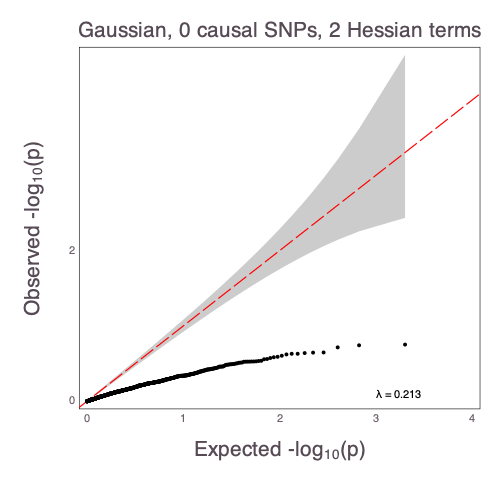

In [219]:
qq(pvals, dpi=100, titles="Gaussian, $k causal SNPs, 2 Hessian terms")
display("image/png", read("qqplot.png"))

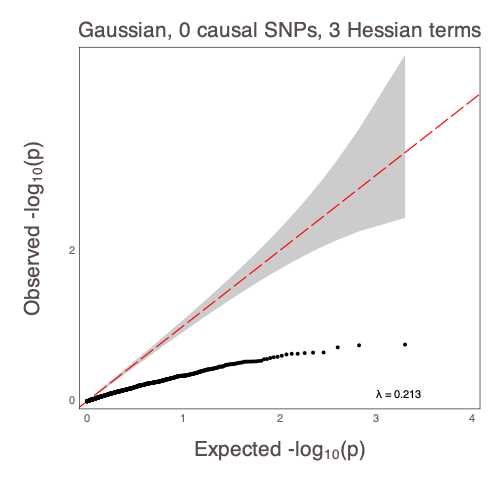

In [197]:
qq(pvals, dpi=100, titles="Gaussian, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

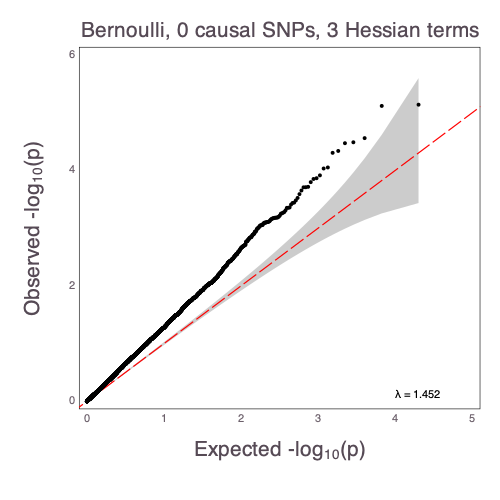

In [141]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

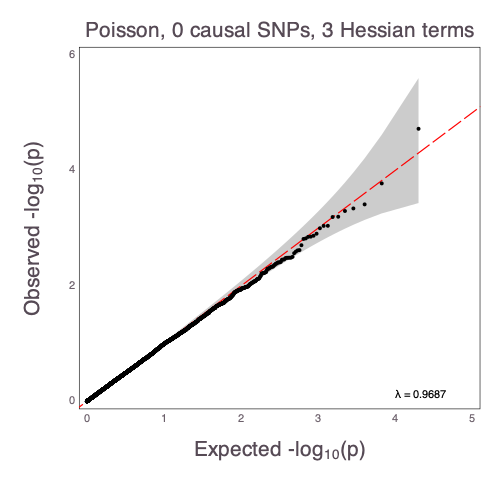

In [157]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

## QQ Plots (tweaked)

+ I can tweak calculation of $\nabla res(\beta)$ so that the resulting p-values for Normal and Bernoulli base look "correct".
+ This uses the full Hessian to calculate W, Q, R. 
+ For Poisson I haven't found a way to tweak them. 

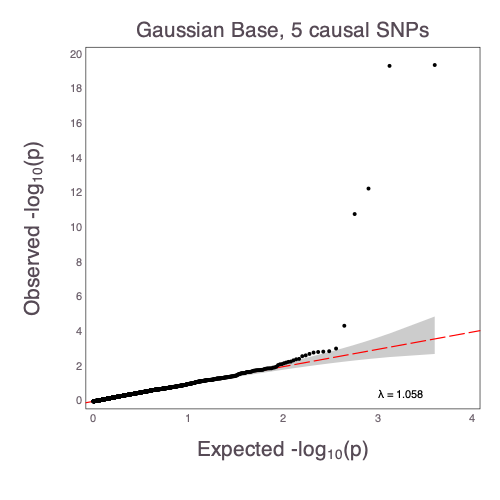

In [320]:
qq(pvals, dpi=100, titles="Gaussian Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

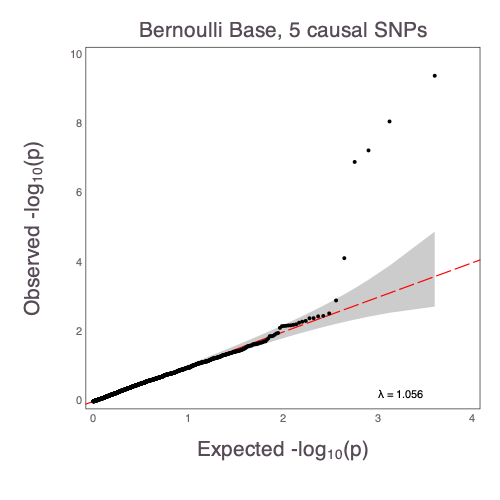

In [301]:
qq(pvals, dpi=100, titles="Bernoulli Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))